Решение кейса:
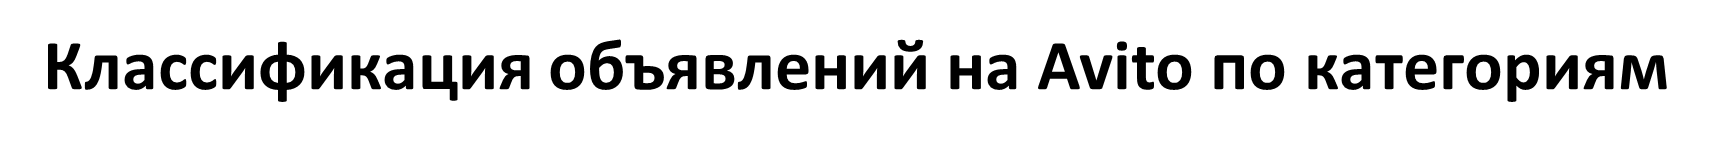

Решение разделено на следующие этапы:

-импорт данных и первичную обработку

-обработку текста

-построение и отбор модели

-проверка Accuracy на разных уровнях иерархии

-применение модели на тестовой выборке

Код оформлялся в Python 3.x

# Импорт данных и первичная обработка

In [1]:
import pandas as pd
import numpy as np

In [159]:
data = pd.read_csv('test.csv')
data.head(10)

,item_id,title,description,price
0,489517,Стоик журнальный сталь,продам журнальный столик изготавливаю столы из...,10000.0
1,489518,iPhone 5 64Gb,"Телефон в хорошем состоянии. Комплект, гаранти...",12500.0
2,489519,Утеплитель,ТЕПЛОПЕЛЕН-ЛИДЕР ТЕПЛА!!! Толщина утеплителя :...,250.0
3,489520,Пальто демисезонное,Продам пальто женское (букле) в отличном состо...,1700.0
4,489521,Samsung syncmaster T200N,"Условно рабочий, проблема в панели настройки м...",1000.0
5,489522,Дверь Profil Doors Х21,Дверь межкомнатная ProfilDoors 21Х. Серия Х пр...,6600.0
6,489523,"Новый Cort CR100 в отличном состоянии, с коробкой","Доброго времени суток, Томичи. Срочно нужны де...",13900.0
7,489524,Кресла,Продаются 2кресла в хорошем состоянии за два 600,600.0
8,489525,Сверх быстрый YotaPhone 2,"Да , разбит дисплей , но когда экран работает ...",6000.0
9,489526,Люстра ArteLamp medici A9468LM-5BR,ВНИМАНИЕ РАСПРОДАЖА !!!! Люстра ArteLamp MEDIC...,3650.0


Объединим текстовые поля в одну колонку, информацию мы не потеряем, но когда будем использовать Countvectorizer, то это позволит уменьшить размерность, так как иначе для одного и того же слова будет создаваться компонента вектора для tittle и для description

In [160]:
Text = data['title'] + ' ' + data['description']

In [161]:
df = pd.concat([data['item_id'], Text, data['price']], axis = 1)

In [10]:
df.head(10)

,item_id,0,price
0,489517,Стоик журнальный сталь продам журнальный столи...,10000.0
1,489518,iPhone 5 64Gb Телефон в хорошем состоянии. Ком...,12500.0
2,489519,Утеплитель ТЕПЛОПЕЛЕН-ЛИДЕР ТЕПЛА!!! Толщина у...,250.0
3,489520,Пальто демисезонное Продам пальто женское (бук...,1700.0
4,489521,"Samsung syncmaster T200N Условно рабочий, проб...",1000.0
5,489522,Дверь Profil Doors Х21 Дверь межкомнатная Prof...,6600.0
6,489523,"Новый Cort CR100 в отличном состоянии, с короб...",13900.0
7,489524,Кресла Продаются 2кресла в хорошем состоянии з...,600.0
8,489525,"Сверх быстрый YotaPhone 2 Да , разбит дисплей ...",6000.0
9,489526,Люстра ArteLamp medici A9468LM-5BR ВНИМАНИЕ РА...,3650.0


# Обработка текста

In [13]:
import re
import pymorphy2
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Антон\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

Оставим лишь буквы руского и английского алфавита, приведем к нижнему регистру

In [14]:
def deleteExtraSymbols(line):
    return re.sub(' +',' ', re.sub(u'[^А-Яа-яA-Za-z ]', u' ', line).lower().rstrip().strip())

In [15]:
df[0] = df[0].apply(deleteExtraSymbols)

In [16]:
df[0].head(10)

0    стоик журнальный сталь продам журнальный столи...
1    iphone gb телефон в хорошем состоянии комплект...
2    утеплитель теплопелен лидер тепла толщина утеп...
3    пальто демисезонное продам пальто женское букл...
4    samsung syncmaster t n условно рабочий проблем...
5    дверь profil doors х дверь межкомнатная profil...
6    новый cort cr в отличном состоянии с коробкой ...
7    кресла продаются кресла в хорошем состоянии за...
8    сверх быстрый yotaphone да разбит дисплей но к...
9    люстра artelamp medici a lm br внимание распро...
Name: 0, dtype: object

Продолжим обрабатывать текст, используем лемматизацию

In [17]:
morph = pymorphy2.MorphAnalyzer()

In [18]:
def lemmatization(line):
    result = []
    for word in line.split():
        result.append(morph.parse(word)[0].normal_form)               
    return ' '.join(result)

In [19]:
df[0] = df[0].apply(lemmatization)

In [20]:
df[0].head(10)

0    стоик журнальный сталь продать журнальный стол...
1    iphone gb телефон в хороший состояние комплект...
2    утеплитель теплопелена лидер тепло толщина уте...
3    пальто демисезонный продать пальто женский бук...
4    samsung syncmaster t n условно рабочий проблем...
5    дверь profil doors х дверь межкомнатный profil...
6    новый cort cr в отличный состояние с коробка д...
7    кресло продаваться кресло в хороший состояние ...
8    сверх быстрый yotaphone да разбитый дисплей но...
9    люстра artelamp medici a lm br внимание распро...
Name: 0, dtype: object

Уберем стоп-слова

In [21]:
def stopword(line):
    stopWords = set(stopwords.words('russian'))
    wordsFiltered = []

    for w in line.split():
        if w not in stopWords:
            wordsFiltered.append(w)
    return' '.join(wordsFiltered)

In [22]:
df[0] = df[0].apply(stopword)

In [23]:
df[0].head(10)

0    стоик журнальный сталь продать журнальный стол...
1    iphone gb телефон хороший состояние комплект г...
2    утеплитель теплопелена лидер тепло толщина уте...
3    пальто демисезонный продать пальто женский бук...
4    samsung syncmaster t n условно рабочий проблем...
5    дверь profil doors х дверь межкомнатный profil...
6    новый cort cr отличный состояние коробка добры...
7          кресло продаваться кресло хороший состояние
8    сверх быстрый yotaphone разбитый дисплей экран...
9    люстра artelamp medici a lm br внимание распро...
Name: 0, dtype: object

Сохраню промежуточный результат

In [28]:
df.to_csv('case_out.csv', encoding='utf_8')

In [29]:
df = pd.read_csv('case_out.csv')

Имеет смысл объединять словосочетания, которые часто встречаются. Это может помочь, например, для учета компьютерных игр, 
или для объединения слов, которые кто-то пишет слитно, а кто то раздельно, например, 'x box' и 'xbox'

In [30]:
pair_words_frequency = dict()

for s in df['0']:
    for i in range(len(s.split())-1):
        pair = s.split()[i] + '_' + s.split()[i+1]
        if pair in pair_words_frequency:
            pair_words_frequency[pair] += 1
        else:
            pair_words_frequency[pair] = 1

In [31]:
def collocation(s):
    line = []
    for i in range(len(s.split()) - 1):
        pair1 = s.split()[i] + '_' + s.split()[i+1]
        a = pair_words_frequency.get(pair1)
        if a > 300:
            line.append(pair1)
            line.append(s.split()[i]) # будут рассматриваться как отдельные слова 
        else:
            line.append(s.split()[i])
    return' '.join(line)

In [32]:
df['0'] = df['0'].apply(collocation)

In [33]:
df['0'].head()

0    стоик журнальный сталь продать журнальный_стол...
1    iphone_gb iphone gb телефон_хороший телефон хо...
2    утеплитель теплопелена лидер тепло толщина уте...
3    пальто демисезонный продать пальто женский бук...
4    samsung_syncmaster samsung syncmaster t n усло...
Name: 0, dtype: object

In [34]:
df.to_csv('case_out_collocation.csv')

В описаниях объявлений возможны многочисленные опечатки. Напишем функцию исправления опечаток и пременим ее ко всем словам в описаниях. 

Для начала создадим словарь, где ключами будут все слова наших текстов, а значениями - числа вхождений этих слов во все объявления.

In [35]:
word_frequency_full = dict()

for s in df['0']:
    for word in s.split():
        if word in word_frequency_full:
            word_frequency_full[word] += 1
        else:
            word_frequency_full[word] = 1

Примеры опечаток и их число в тексте:

In [36]:
word_frequency_full.get('пидаль')

1

In [44]:
word_frequency_full.get('педаль')

1918

In [45]:
word_frequency_full.get('комплект')

31457

In [46]:
word_frequency_full.get('камплект')

10

Функция, возвращающая все слова, которые находятся на расстоянии одной правки от исходного слова:

In [37]:
 def edits1(word):
    alphabet = u'абвгдеёжзиклмнопрстуфхцчшщъыьэюяabcdefghijklmnopqrstuvwxyz'
    splits = [(word[:i], word[i:]) for i in range(len(word) + 1)]
    deletes = [a + b[1:] for a, b in splits if b]
    transposes = [a + b[1] + b[0] + b[2:] for a, b in splits if len(b)>1]
    replaces = [a + c + b[1:] for a, b in splits for c in alphabet if b]
    inserts = [a + c + b     for a, b in splits for c in alphabet]
    return list(set(deletes + transposes + replaces + inserts))

На расстоянии 2 правок:

In [38]:
def edits2(word):
    return list(set(e2 for e1 in edits1(word) for e2 in edits1(e1)))

В функцию исправления опечаток передается слово, для него ищутся все возможные правильные варианты написания из всех слов которые есть в нашем тексте. Из всех вариантов выбирается наиболее встречающийся.

In [39]:
def correct(word): 
    vocab = word_frequency_full
    
    candidates = filter(lambda x: x in vocab, edits1(word)) or filter(lambda x: x in vocab, edits2(word))
    try:
        a = max(candidates, key=vocab.get)
    except:
        a = word
    return a

In [47]:
correct('камплект')

'комплект'

In [48]:
correct('комплект')

'комплект'

In [49]:
correct('x_box')

'xbox'

In [56]:
correct('стоик')

'столик'

In [40]:
def wordcorrection(line):
    wordsFilteredline = []
    for w in line.split():
        wordsFilteredline.append(correct(w))
    return' '.join(wordsFilteredline)

In [41]:
df['0'] = df['0'].apply(wordcorrection)

In [50]:
df.to_csv('case_out_word_correction.csv', encoding = 'utf8')

В объявлениях можно встретить слова, которые встречаются слишком часто, но при этом не несут смысла для определения класса к которому относятся. Например, слово 'состояние' и словосочетания с ним, как 'идеальное состояние' присутствует в разных объявлениях из разных иерархий и поэтому может только мешать классификатору

In [51]:
new_word_frequency = dict()

for s in df['0']:
    for word in s.split():
        if word in new_word_frequency:
            new_word_frequency[word] += 1
        else:
            new_word_frequency[word] = 1

In [52]:
new_word_frequency_selected = {word: frequency for word, frequency in new_word_frequency.items() if (frequency < 70000)}

In [53]:
def finalfilter(line):
    wordsFiltered = []

    for w in line.split():
            if w in new_word_frequency_selected:
                wordsFiltered.append(w)
    return' '.join(wordsFiltered)

In [54]:
df['0'] = df['0'].apply(finalfilter)

In [55]:
df.to_csv('case_out_filter.csv', encoding = 'utf8')

Заметим, что для построения модели колонка с ценами в объявлениях не используется из аналогичных сообажений о том, что так как одинаковые цены могут у разных товарах в разных иерархиях, то это может испортить модель.

In [57]:
df.head(10)

,Unnamed: 0,item_id,0,price
0,0,489517,столик журнальный стать продать журнальный_сто...,10000.0
1,1,489518,iphone_gb iphone gb телефон_хороший телефон хо...,12500.0
2,2,489519,утеплитель теплопелена лидер тело толщина утеп...,250.0
3,3,489520,пальто демисезонный продать пальто женский бук...,1700.0
4,4,489521,samsung_syncmaster samsung syncmaster словно р...,1000.0
5,5,489522,дверь profi door дверь_межкомнатный дверь межк...,6600.0
6,6,489523,новый core c отличный_состояние отличный состо...,13900.0
7,7,489524,кресло продаваться кресло хороший_состояние хо...,600.0
8,8,489525,верх быстрый yotaphone разбитый дисплей экран ...,6000.0
9,9,489526,люстра artelamp medica m b внимание распродажа...,3650.0


Видно, что опечатки исправлены, например, в первой строчке было слово 'стоик' вместо 'столик' и некоторые часто употребимые словосочетания объеденены в одно 'слово'

# Построение модели

Уже предобработанная мной таким же образом выборка train.csv

In [2]:
df = pd.read_csv('case_out_filter.csv')

In [3]:
df2 = pd.read_csv('out2.csv')

Для начала будем перебирать модель только с теrстовой информации

Будем перебирать модели с помощью GridSearch, для определения лучших параметров.

In [4]:
from sklearn.model_selection import GridSearchCV

In [5]:
from sklearn import cross_validation

D:\anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [23]:
ROCtrainTRN, ROCtestTRN, ROCtrainTRG, ROCtestTRG = cross_validation.train_test_split(df2, df2['category_id'], test_size=0.25) 

В качестве алгоритма воспользуемся Наивным Байессовским классификатором (другие алгоритмы после gridsearch показали результаты хуже) 

Для представления текста в вектор будем использовать CountVectorizer и TfidfTransformer

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score

In [10]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                  ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB())])

In [11]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
               'tfidf__use_idf': (True, False),
                'clf__alpha': (1e-2, 1e-3)}

In [12]:
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)

In [13]:
gs_clf = gs_clf.fit(ROCtrainTRN['0'], ROCtrainTRN['category_id'])

In [14]:
gs_clf.best_score_
gs_clf.best_params_

{'clf__alpha': 0.01, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}

В итоге:

In [24]:
best_vect = CountVectorizer(ngram_range = (1, 2))
best_tfidf = TfidfTransformer(use_idf = False)

In [25]:
X_train_best = best_vect.fit(ROCtrainTRN['0'])
X_train_best = best_vect.transform(ROCtrainTRN['0'])

In [26]:
X_train_tfidf_best = best_tfidf.fit(X_train_best)
X_train_tfidf_best = best_tfidf.transform(X_train_best)

In [27]:
clf = MultinomialNB(alpha = 0.01).fit(X_train_tfidf_best, ROCtrainTRN['category_id'])

In [28]:
Kn_X_new_best = best_vect.transform(ROCtestTRN['0'])
Kn_X_new_best = best_tfidf.transform(Kn_X_new_best)
predicted = clf.predict(Kn_X_new_best)

In [29]:
accuracy_score(predicted, ROCtestTRG)

0.87420330119300538

# NB accuracy_score - 0.87420330119300538

Хороший результат, попробую другие модели

In [30]:
from sklearn.linear_model import SGDClassifier

In [34]:
text_clf_svm = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf_svm', SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=1e-3))])

In [38]:
from sklearn.grid_search import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
               'tfidf__use_idf': (True, False),
               'clf_svm__alpha': (1e-2, 1e-3)}

In [39]:
gs_clf_svm = GridSearchCV(text_clf_svm, parameters, n_jobs=-1)

In [40]:
gs_clf_svm = gs_clf_svm.fit(ROCtrainTRN['0'], ROCtrainTRN['category_id'])

D:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


In [41]:
gs_clf_svm.best_score_
gs_clf_svm.best_params_

{'clf_svm__alpha': 0.001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}

Тогда:

In [42]:
best_vect = CountVectorizer(ngram_range = (1, 2))
best_tfidf = TfidfTransformer(use_idf = True)

In [43]:
X_train_best = best_vect.fit(ROCtrainTRN['0'])
X_train_best = best_vect.transform(ROCtrainTRN['0'])

In [44]:
X_train_tfidf_best = best_tfidf.fit(X_train_best)
X_train_tfidf_best = best_tfidf.transform(X_train_best)

In [45]:
clf = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3).fit(X_train_tfidf_best, ROCtrainTRN['category_id'])

D:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [46]:
Kn_X_new_best = best_vect.transform(ROCtestTRN['0'])
Kn_X_new_best = best_tfidf.transform(Kn_X_new_best)
predicted = clf.predict(Kn_X_new_best)

In [47]:
accuracy_score(predicted, ROCtestTRG)

0.81735577708775942

In [61]:
clf = SGDClassifier().fit(X_train_tfidf_best, ROCtrainTRN['category_id'])

D:\anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [62]:
Kn_X_new_best = best_vect.transform(ROCtestTRN['0'])
Kn_X_new_best = best_tfidf.transform(Kn_X_new_best)
predicted = clf.predict(Kn_X_new_best)

In [63]:
accuracy_score(predicted, ROCtestTRG)

0.84688674620035953

# SVM accuracy_score - 0.84688674620035953

Другие алгоритмы (RandomForest, Kneighbour) не дали мне лучшего результата.

Итого:

SVM - 0.84688674620035953

NB - 0.87420330119300538

В качестве итоговой модели выберу NB

# Посчитаю Accuracy на разных уровнях иерархии

Первый уровень иерархии классов:

In [17]:
tech = list(range(0,15))
home = list(range(15,30))
things = list(range(30,42))
hobby = list(range(42,54))

In [20]:
def TRGToFirstlevel(line):
    if line in tech:
        return 0
    if line in home:
        return 1
    if line in things:
        return 2
    if line in hobby:
        return 3

In [23]:
new_category_id = df2['category_id'].apply(TRGToFirstlevel)

Применим модель:

In [25]:
ROCtrainTRN, ROCtestTRN, ROCtrainTRG, ROCtestTRG = cross_validation.train_test_split(df2, new_category_id, test_size=0.25) 

In [26]:
best_vect = CountVectorizer(ngram_range = (1, 2))
best_tfidf = TfidfTransformer(use_idf = False)

X_train_best = best_vect.fit(ROCtrainTRN['0'])
X_train_best = best_vect.transform(ROCtrainTRN['0'])

X_train_tfidf_best = best_tfidf.fit(X_train_best)
X_train_tfidf_best = best_tfidf.transform(X_train_best)

clf = MultinomialNB(alpha = 0.01).fit(X_train_tfidf_best, ROCtrainTRG)

Kn_X_new_best = best_vect.transform(ROCtestTRN['0'])
Kn_X_new_best = best_tfidf.transform(Kn_X_new_best)
predicted = clf.predict(Kn_X_new_best)

In [27]:
accuracy_score(predicted, ROCtestTRG)

0.95736231410361172

Как и ожидалось самый первый уровень иерархии предсказать проще всего

Второй уровень иерархии классов:

Чтобы получить классы, импортируем документ 'category.csv' и разобьем на классы по второму уровню:

In [52]:
import csv

In [84]:
with open('category.csv', 'r') as fp:
    reader = csv.reader(fp, delimiter=',')
    data_read = [row for row in reader]

categories = []
for line in data_read:
    categories.append(line[1:3])

In [85]:
categories = pd.DataFrame(categories, columns = ['First','Second'])

In [86]:
c = pd.concat([categories, pd.Series(list(range(54)), name = 'index')], axis = 1)

In [125]:
c.head(10)

,First,Second,index
0,Бытовая электроника,Телефоны,0
1,Бытовая электроника,Ноутбуки,1
2,Бытовая электроника,Телефоны,2
3,Бытовая электроника,Планшеты и электронные книги,3
4,Бытовая электроника,Игры,4
5,Бытовая электроника,Аудио и видео,5
6,Бытовая электроника,Телефоны,6
7,Бытовая электроника,Настольные компьютеры,7
8,Бытовая электроника,Игры,8
9,Бытовая электроника,Телефоны,9


In [120]:
cl = list(c.groupby('Second')['index'].groups.values())

In [123]:
classes = []
for i in cl:
    classes.append(list(i))
    print(list(i))

[5, 12]
[48]
[26, 29]
[53]
[4, 8]
[43, 51]
[44, 45]
[37]
[16, 18, 19, 22, 23, 27, 28]
[50, 52]
[7]
[1]
[31, 33, 35, 38, 39]
[49]
[3]
[20]
[24]
[15, 17, 21, 25]
[42, 46, 47]
[0, 2, 6, 9, 10, 11]
[30, 32, 34, 41]
[13, 14]
[36, 40]


In [128]:
def TRGToSecondlevel(line):
    for i in range(len(classes)):
        if line in classes[i]:
            return i

In [129]:
second_category_id = df2['category_id'].apply(TRGToSecondlevel)

Применим модель

In [133]:
ROCtrainTRN, ROCtestTRN, ROCtrainTRG, ROCtestTRG = cross_validation.train_test_split(df2, second_category_id, test_size=0.25) 

In [134]:
best_vect = CountVectorizer(ngram_range = (1, 2))
best_tfidf = TfidfTransformer(use_idf = False)

X_train_best = best_vect.fit(ROCtrainTRN['0'])
X_train_best = best_vect.transform(ROCtrainTRN['0'])

X_train_tfidf_best = best_tfidf.fit(X_train_best)
X_train_tfidf_best = best_tfidf.transform(X_train_best)

clf = MultinomialNB(alpha = 0.01).fit(X_train_tfidf_best, ROCtrainTRG)

Kn_X_new_best = best_vect.transform(ROCtestTRN['0'])
Kn_X_new_best = best_tfidf.transform(Kn_X_new_best)
predicted = clf.predict(Kn_X_new_best)

In [135]:
accuracy_score(predicted, ROCtestTRG)

0.93288118973688516

# Применим модель на тестовой выборке

In [137]:
best_vect = CountVectorizer(ngram_range = (1, 2))
best_tfidf = TfidfTransformer(use_idf = False)

X_train_best = best_vect.fit(df2['0'])
X_train_best = best_vect.transform(df2['0'])

X_train_tfidf_best = best_tfidf.fit(X_train_best)
X_train_tfidf_best = best_tfidf.transform(X_train_best)

In [138]:
clf = MultinomialNB(alpha = 0.01).fit(X_train_tfidf_best, df2['category_id'])

In [139]:
Kn_X_new_best = best_vect.transform(df['0'])
Kn_X_new_best = best_tfidf.transform(Kn_X_new_best)
predicted = clf.predict(Kn_X_new_best)

In [140]:
predicted

array([22,  0, 15, ...,  7, 18, 29], dtype=int64)

In [141]:
s2 = pd.Series(predicted, name = 'category_id')

In [142]:
Result = pd.concat([df['item_id'], s2], axis = 1)

In [143]:
Result.head()

,item_id,category_id
0,489517,22
1,489518,0
2,489519,15
3,489520,33
4,489521,13


In [150]:
Result.to_csv('result.csv', encoding = 'utf8' , index = None)